Here, We will identify specific clinical concepts in patient notes. Specifically, you'll develop an automated method to map clinical concepts from an exam rubric (e.g., “diminished appetite”) to various ways in which these concepts are expressed in clinical patient notes written by medical students (e.g., “eating less,” “clothes fit looser”). Great solutions will be both accurate and reliable.

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
import re
import nltk
from ast import literal_eval
from itertools import chain

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/nbme-score-clinical-patient-notes'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nbme-score-clinical-patient-notes/sample_submission.csv
/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv
/kaggle/input/nbme-score-clinical-patient-notes/features.csv
/kaggle/input/nbme-score-clinical-patient-notes/train.csv
/kaggle/input/nbme-score-clinical-patient-notes/test.csv


In [3]:
train =pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/train.csv')
patiens_note = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv')
features = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/features.csv')
test= pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/test.csv')

***DATA EXTRACTION AND UNDERSTANDING***

In [4]:
# Importing patient Notes Data 
print(patiens_note.shape)
print(patiens_note.nunique())
patiens_note.head()

(42146, 3)
pn_num        42146
case_num         10
pn_history    42146
dtype: int64


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [5]:
# Importing Features Data Representing different kind of features for each clinical case 
print(features.shape)
print(features.nunique())
features.head()

(143, 3)
feature_num     143
case_num         10
feature_text    131
dtype: int64


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [6]:
# Importing train Data (Each row represent a Unique Identifier for Patient-Feature Pair)
print(train.shape)
print(train.nunique())
train.head()

(14300, 6)
id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [7]:
print(train.shape)
print(train.nunique())
train.head()

(14300, 6)
id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [8]:
#row and columns of train data
train.shape

(14300, 6)

In [9]:
#chek null value
train.isnull().sum().sum()

0

In [10]:
#view from patience note
patiens_note.head(5)

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [11]:
patiens_note.shape

(42146, 3)

***Exploratory Data Analysis (EDA)***

In [12]:
#value counts
temp = patiens_note.groupby('case_num').count()['pn_history'].reset_index().sort_values(by='pn_history', ascending=False)
temp.style.background_gradient(cmap='Purples')

,case_num,pn_history
3,3,9753
5,5,6909
4,4,5405
9,9,5151
8,8,4196
7,7,4101
0,0,2268
2,2,1958
6,6,1597
1,1,808


<Axes: xlabel='case_num', ylabel='count'>

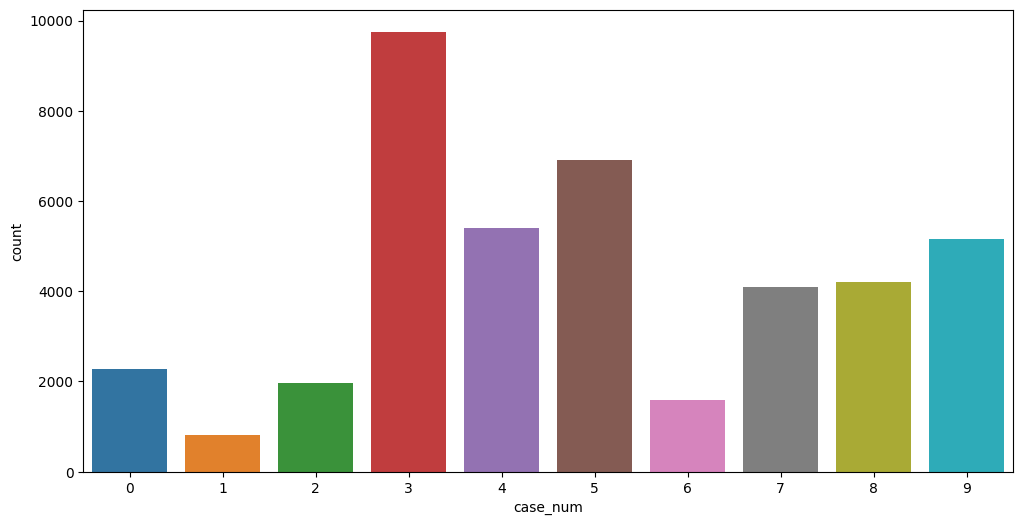

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(x='case_num', data=patiens_note)

In [14]:
fig=go.Figure(go.Funnelarea(
    text=temp.case_num,
    values=temp.pn_history,
    title= {"position":"top center", "text": "Funnel-chart on Case Number Distribution"}))
fig.show()

**Most Common**

In [15]:
#Most common word in the target Selected
patiens_note['temp']= patiens_note['pn_history'].apply(lambda x: str(x).split())
top= Counter([item for sublist in patiens_note['temp'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns=["Common_words", 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,and,134345
1,with,95369
2,of,92239
3,no,82617
4,a,75820
5,the,70754
6,in,70346
7,has,68659
8,is,62703
9,for,57314


In [16]:
fig = px.bar(temp,x="count", y="Common_words", 
             title="Common words in Selected Text", orientation='h', width=700, height=700,color='Common_words')
fig.show()


**Remove Stop words and check common word again**

In [17]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
patiens_note['temp'] = patiens_note['temp'].apply(lambda x: remove_stopword(x))

In [18]:
top = Counter([item for sublist in patiens_note['temp'] for item in sublist])
temp=pd.DataFrame(top.most_common(20))
temp=temp.iloc[1:,:]
temp.columns=["Common_words",'count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,pain,40083
2,2,38697
3,No,35750
4,none,33490
5,denies,30296
6,-,22866
7,last,22159
8,3,21139
9,weeks,20609
10,PMH:,19741


In [19]:
fig = px.treemap(temp, path=['Common_words'], values='count', title='Tree of Most Common words')
fig.show()

In [20]:
most_popular_case = patiens_note[patiens_note['case_num']==3]

In [21]:
#MosT common  words in 
top = Counter([item for sublist in most_popular_case['temp'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,pain,26939
1,2,13638
2,He,13548
3,No,9174
4,back,7629
5,35,7509
6,epigastric,6950
7,none,6402
8,pain.,6201
9,denies,6157


In [22]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Words popular cases Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

**Sample of Patience Note**

In [23]:
print(patiens_note["pn_history"].iloc[15])

Mr. Cleveland is a 17 yo male who presents today for 2-3 history of heart pounding episodes. Has had 5-6 epidosdes total that last 3-4 minutes. Usually just heart pounding but most recent episode accompanied by SOB, chest pressure in center of chest, and lightheadedness. Was watching TV when last epidose happened. Random time of day. Nothing makes better or worse.
PMH: healthy
Medications: roommates aderol
allergies: none
PSH: None
FH: Father living but had MI last year. Mother has not otherwise specified thyroid problem. No history of sudden cardiac death.
SH: NO smoking, 3-4 beer on weekened night, occassional marajuana use, student, relationships with friends and family are goood. No streess. No anxiety. 
ROS: Postivie: Palpitations, SOB, chest pressure, lightheadedness with episodes
Negative: headaches, vision changes, weight loss, heat intolerance, nausea vomiting, changes in bowel or bladder function, abdominal pain. 



**Distribution of top n-grams for pn_history**

In [24]:
# if n_words=1 -> unigrams, if n_words=2 -> bigrams..
def get_top_Nwords(corpus, n=None, remove_stop_words=False, n_words=1):
    if remove_stop_words:
        vec = CountVectorizer(stop_words='english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)
    
    bag_ofWords =vec.transform(corpus)
    sum_words = bag_ofWords.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [25]:
common_words = get_top_Nwords(patiens_note['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

sexually active 16461
weeks ago 14173
chest pain 12695
months ago 11170
drug use 10382
ros negative 9517
pmh psh 8969
year old 8922
nausea vomiting 6939
35 yo 6192
abdominal pain 6062
allergies nkda 5925
past weeks 5523
years ago 5377
weight loss 5272
falling asleep 5148
epigastric pain 5012
old female 4676
breast cancer 4672
active boyfriend 4612


**Bigram distribution**

In [26]:
common_words = get_top_Nwords(patiens_note['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

sexually active 16461
weeks ago 14173
chest pain 12695
months ago 11170
drug use 10382
ros negative 9517
pmh psh 8969
year old 8922
nausea vomiting 6939
35 yo 6192
abdominal pain 6062
allergies nkda 5925
past weeks 5523
years ago 5377
weight loss 5272
falling asleep 5148
epigastric pain 5012
old female 4676
breast cancer 4672
active boyfriend 4612


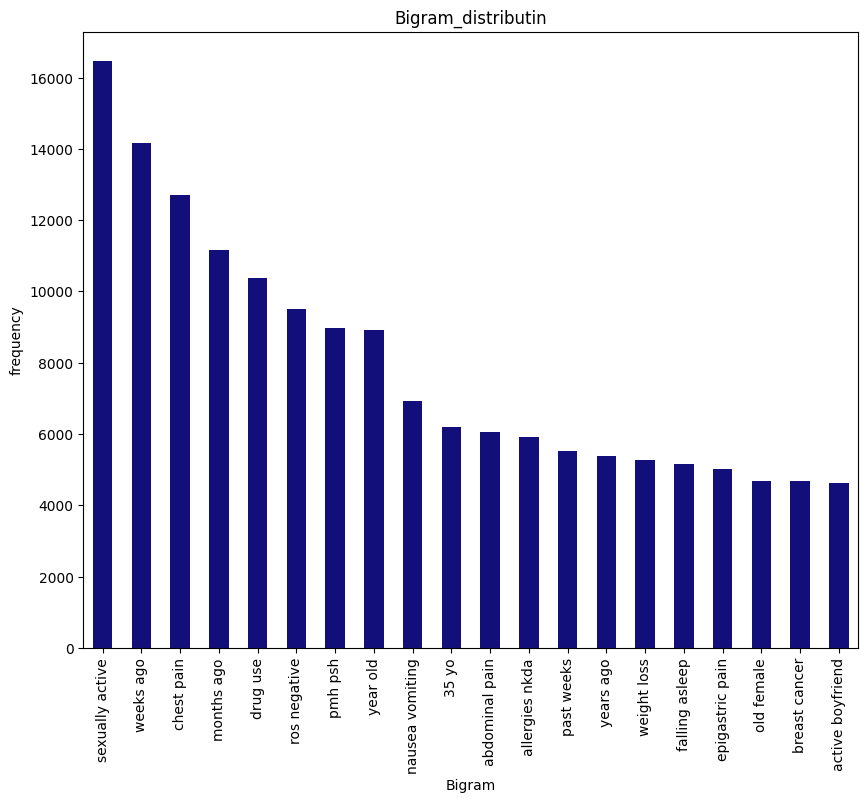

In [27]:
train_temp =pd.DataFrame(common_words, columns=['text', 'count'])
fig = plt.figure(figsize=(10,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Bigram_distributin")
ax1.set_xlabel('Bigram')
ax1.set_ylabel("frequency")
plt.show()

**Tigram distribution**

In [28]:
common_words = get_top_Nwords(patiens_note['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

year old female 4388
sexually active boyfriend 4242
illicit drug use 3540
uncle bleeding ulcer 3413
ros negative pmh 3362
sexually active husband 2878
35 year old 2872
difficulty falling asleep 2853
pmh psh meds 2584
lmp weeks ago 2265
year old male 2173
chest pain sob 1990
use sexually active 1947
drugs sexually active 1893
fh uncle bleeding 1788
denies chest pain 1781
pmh psh fh 1745
15 30 minutes 1657
drug use sexually 1607
mr hamilton 35 1476


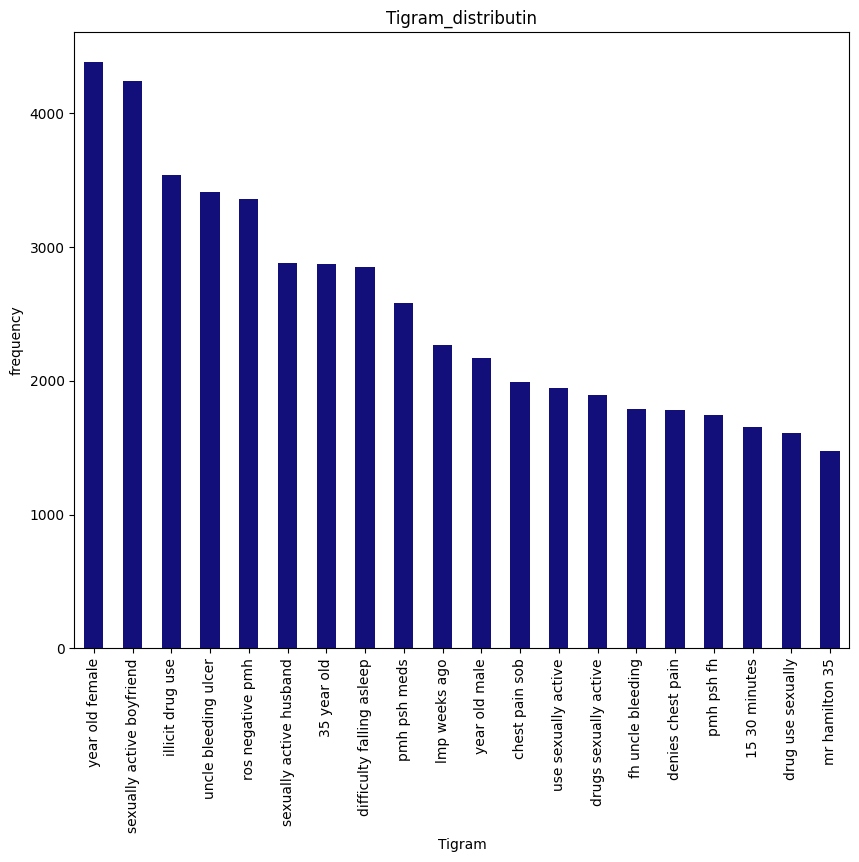

In [29]:
train_temp =pd.DataFrame(common_words, columns=['text', 'count'])
fig = plt.figure(figsize=(10,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Tigram_distributin")
ax1.set_xlabel('Tigram')
ax1.set_ylabel("frequency")
plt.show()

**WordCloud**

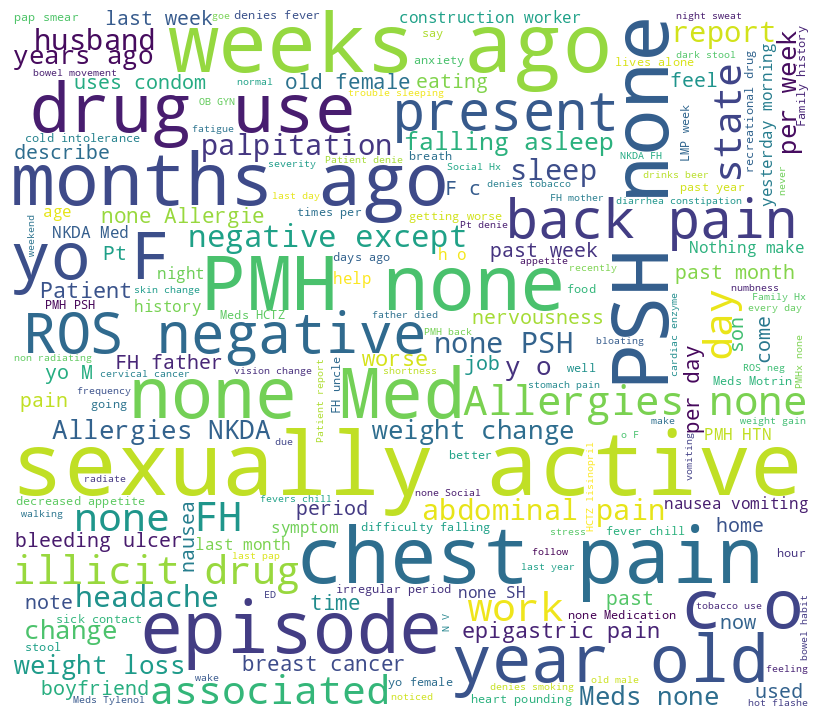

In [30]:
stopwords=set(STOPWORDS)
wordclouds=WordCloud(width=800, 
                    height=700,
                    background_color='white',
                    max_font_size=120,
                    min_font_size=10,
                    stopwords=stopwords).generate(''.join(patiens_note['pn_history']))

#plot the worldcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordclouds)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [31]:
def pre_processing_text(text, flg_steam=False,flg_lemm=True):
    #lower case
    text=re.sub(r'[^\w\s]','',str(text).lower().strip())
    #tokenize
    words = text.split()
    #stop steamming
    if flg_steam==True:
        ps=nltk.stem.porter.PorterStemmer()
        words = [ps.stem(word) for word in words]
    #lemmitization
    if flg_lemm == True:
        lem=nltk.stem.wordnet.WordNetLemmatizer()
        words = [lem.lemmatize(word) for word in words]
    
    #back to string from list
    text = ' '.join(words)
    return text

**Value count in Features**

In [32]:
features_note = features.groupby("case_num").count()
fig = px.bar(data_frame =features_note, 
             x = features_note.index,
             y = 'feature_num' , 
             color_discrete_sequence=['#D63230'],
             orientation='h',
             color_continuous_scale="Emrld")
fig.show()

In [33]:
temp = features.groupby('case_num').count()['feature_text'].reset_index().sort_values(by='feature_text', ascending=False)
temp.style.background_gradient(cmap='Purples')

,case_num,feature_text
5,5,18
8,8,18
2,2,17
9,9,17
3,3,16
0,0,13
1,1,13
6,6,12
4,4,10
7,7,9


In [34]:
fig=go.Figure(go.Funnelarea(
    text=temp.case_num,
    values=temp.feature_text,
    title= {"position":"top center", "text": "Funnel-chart on Case Number Distribution"}))
fig.show()

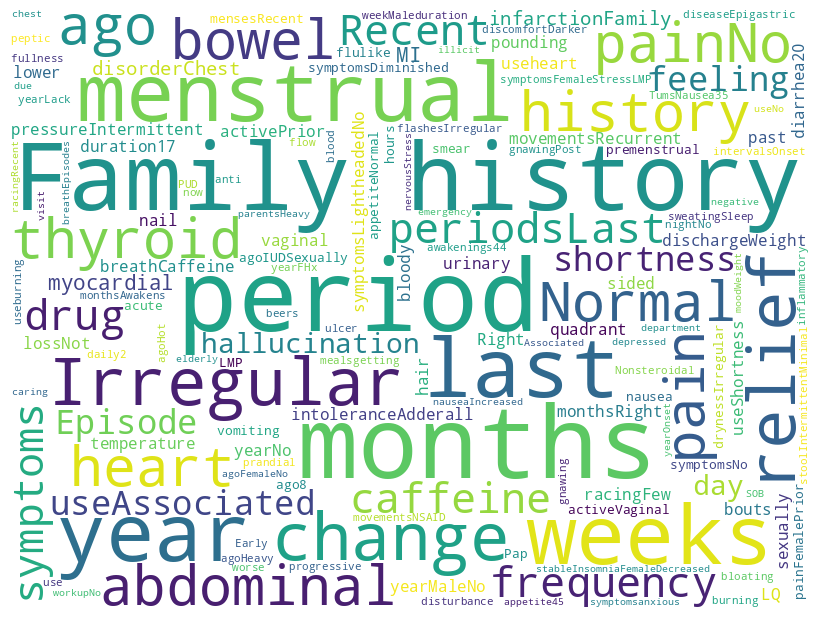

In [35]:
stopwords=set(STOPWORDS)
wordclouds=WordCloud(width=800, 
                    height=600,
                    max_font_size=100,
                    background_color='white',
                    min_font_size=10,
                    stopwords=stopwords).generate(''.join(features['feature_text']))

#plot the worldcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordclouds)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [36]:
BASE_URL = "../input/nbme-score-clinical-patient-notes"


def process_feature_text(text):
    return text.replace("-OR-", ";-").replace("-", " ")


def prepare_datasets():
    features = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    df = pd.read_csv(f"{BASE_URL}/train.csv")
    df["annotation_list"] = [literal_eval(x) for x in df["annotation"]]
    df["location_list"] = [literal_eval(x) for x in df["location"]]

    merged = df.merge(notes, how="left")
    merged = merged.merge(features, how="left")

    merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
    merged["feature_text"] = merged["feature_text"].apply(lambda x: x.lower())
    merged["pn_history"] = merged["pn_history"].apply(lambda x: x.lower())

    return merged

In [37]:
df = prepare_datasets()


In [38]:
from transformers import BertTokenizer, BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [39]:
first = df.iloc[0]
first

id                                                         00016_000
case_num                                                           0
pn_num                                                            16
feature_num                                                        0
annotation                          ['dad with recent heart attcak']
location                                                 ['696 724']
annotation_list                       [dad with recent heart attcak]
location_list                                              [696 724]
pn_history         hpi: 17yo m presents with palpitations. patien...
feature_text       family history of mi; family history of myocar...
Name: 0, dtype: object

In [40]:
feature_text, pn_history = first.feature_text, first.pn_history
print("feature_text", feature_text)
print("\n")
print("pn_history", pn_history)

feature_text family history of mi; family history of myocardial infarction


pn_history hpi: 17yo m presents with palpitations. patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). of note patient endorses abusing adderall, primarily to study (1-3 times per week). before recent soccer game, took adderrall night before and morning of game. denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. 
pmhx: none
rx: uses friends adderrall
fhx: mom with "thyroid disease," dad with recent heart attcak
all: none
immunizations: up to date
shx: freshmen in college. endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. sexually active with girlfriend x 

In [41]:
# Let's see how the text look like after it's converted into bert token
tokens = tokenizer.tokenize(feature_text, pn_history)
print("Total Tokens", len(tokens))
print(tokens)

Total Tokens 255
['family', 'history', 'of', 'mi', ';', 'family', 'history', 'of', 'my', '##oca', '##rdial', 'in', '##far', '##ction', 'hp', '##i', ':', '17', '##yo', 'm', 'presents', 'with', 'pal', '##pit', '##ations', '.', 'patient', 'reports', '3', '-', '4', 'months', 'of', 'intermittent', 'episodes', 'of', '"', 'heart', 'beating', '/', 'pounding', 'out', 'of', 'my', 'chest', '.', '"', '2', 'days', 'ago', 'during', 'a', 'soccer', 'game', 'had', 'an', 'episode', ',', 'but', 'this', 'time', 'had', 'chest', 'pressure', 'and', 'felt', 'as', 'if', 'he', 'were', 'going', 'to', 'pass', 'out', '(', 'did', 'not', 'lose', 'con', '##cious', '##ness', ')', '.', 'of', 'note', 'patient', 'end', '##ors', '##es', 'abu', '##sing', 'add', '##eral', '##l', ',', 'primarily', 'to', 'study', '(', '1', '-', '3', 'times', 'per', 'week', ')', '.', 'before', 'recent', 'soccer', 'game', ',', 'took', 'add', '##er', '##ral', '##l', 'night', 'before', 'and', 'morning', 'of', 'game', '.', 'denies', 'short', '##ne

In [42]:
pn_history[696:724]

'dad with recent heart attcak'

In [43]:
out = tokenizer(
        feature_text,
        pn_history,
        truncation=True,
        max_length=1000,
        padding="max_length",
        return_offsets_mapping=True
)

In [44]:
zipped = zip(out.sequence_ids(), out["offset_mapping"])

idx, (seq_id, offsets) = next(enumerate(zipped))
if not seq_id or seq_id == 0:
    print("Seq ID zero, so level is -1 also")

Seq ID zero, so level is -1 also


In [45]:
seq_id = 1 #assume
loc_list = [696, 724]

for idx, (seq_id, offsets)  in enumerate(zip(out.sequence_ids(), out["offset_mapping"])):
    token_start, token_end = offsets
    for feature_start, feature_end in [loc_list]:
        if token_start >= feature_start and token_end <= feature_end:
            print(f"Word {pn_history[token_start:token_end]}, label: 1")

Word dad, label: 1
Word with, label: 1
Word recent, label: 1
Word heart, label: 1
Word at, label: 1
Word tc, label: 1
Word ak, label: 1
